## 基于矩阵低秩分解的图像修复

### Robust PCA

$\min_{L,S} ~~rank(L)+||S||_0 ~~s.t. M=L+S$

rank 和 0范数非凸

核范数约束低秩 1范数约束稀疏

$\min_{L,S} ~~||L||^*+\lambda||S||_1 ~~s.t. M=L+S$

要对$\lambda,\mu$进行手动调参

### Principal Component Pursuit by Alternating Directions

### ADM 交替方向法

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# shrink
def shrink(X, Tau):
    sgn = np.sign(X)
    S = np.abs(X) - Tau
    S[S < 0] = 0.0
    return sgn * S

# the singular value thresholding operator
def svd_thresh(X, Tau):
    U, S, V = np.linalg.svd(X, full_matrices=False)
    return np.dot(np.dot(U,np.diag(shrink(S, Tau))),V)


# RPCA
def RPCA(X, lamda, mu=None, maxIter=5000):
    m, n = X.shape
    norm = np.linalg.norm(X, 'fro')
    L = np.zeros((m, n))
    S = np.zeros((m, n))
    Y = np.zeros((m, n))
    if mu is None:
        mu = m * n / (4 * np.linalg.norm(X, ord=1))
    mu_bar = mu * 1e7
    rho = 1.1
    for i in range(maxIter):
        L = svd_thresh(X - S + (1 / mu) * Y, 1/mu)
        S = shrink(X - L + (1 / mu) * Y, lamda / mu)
        Z = X - L - S
        Y = Y + mu * Z
        mu = min(mu * rho, mu_bar)
        # print(i, np.linalg.norm(Z, 'fro'))
        if np.linalg.norm(Z, 'fro') / norm <= 1e-7 or i == maxIter - 1:
            print('Z:', np.linalg.norm(Z, 'fro'), 'X:', norm)
            print('Iter:', i)
            break
    L[L < 0] = 0.0
    L[L > 255] = 255.0
    S[S < 0] = 0.0
    S[S > 255] = 255.0
    return L, S

### 加速近端梯度 APG

In [3]:
def RPCAPD(D, lamda, mu=None, maxIter=5000):
    m,n = D.shape
    A, A_, A1 = np.zeros((m,n)), np.zeros((m,n)), np.zeros((m,n))
    E, E_, E1 = np.zeros((m,n)), np.zeros((m,n)), np.zeros((m,n))
    Ya, Ye = np.zeros((m,n)), np.zeros((m,n))
    t, t_ = 1, 1
    if mu is None:
        mu = 0.99 * np.linalg.norm(D, ord=2)**2
    for i in range(maxIter):
        A1 = A + (t_-1)/t * (A - A_)
        E1 = E + (t_-1)/t * (E - E_)
        A_, E_ = A, E 
        Ya = A1 - 0.5 * (A1 + E1 - D)
        U, S, V = np.linalg.svd(Ya, full_matrices=False)
        S = np.maximum(S - mu/2, 0)
        A = np.dot(U, np.dot(np.diag(S), V))
        Ye = E1 - 0.5 * (A1 + E1 - D)
        E = np.sign(Ye) * np.maximum(np.abs(Ye) - lamda*mu/2, 0)
        t_ = t
        t = (1 + np.sqrt(1 + 4 * t**2)) / 2
        mu = mu * 0.9
        if np.linalg.norm(D-A-E, ord='fro') < 1e-7 * np.linalg.norm(D, ord='fro'):
            print(np.linalg.norm(D-A-E, ord='fro'), np.linalg.norm(D, ord='fro'))
            print('Iter:',i)
            break
        # print(i,np.linalg.norm(D-A-E, ord='fro'), np.linalg.norm(D, ord='fro'))
    A[A < 0] = 0.0
    A[A > 255] = 255.0
    E[E < 0] = 0.0
    E[E > 255] = 255.0
    return A, E

### 5

Z: 0.0034223399226445965 X: 34490.323715500264
Iter: 116


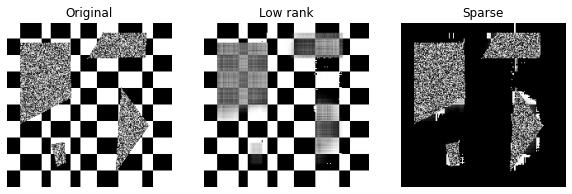

In [59]:
# Read image
img = cv2.imread('source/5.png',cv2.IMREAD_GRAYSCALE)

# RPCA
L, S = RPCA(img, lamda=0.6/np.sqrt(max(img.shape)),mu=3*1e-4, maxIter=5000)

# Show image
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

0.0033269428571811653 34490.323715500264
Iter: 263


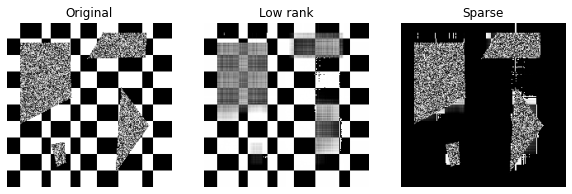

In [71]:
# Read image
img = cv2.imread('source/5.png',cv2.IMREAD_GRAYSCALE)

# RPCA
L, S = RPCAPD(img, lamda=0.55/np.sqrt(max(img.shape)), maxIter=5000)

# Show image
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

### 高斯噪声

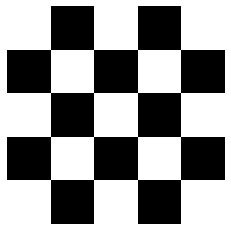

In [14]:
fig = np.zeros([50,50])+255

# 生成一张测试图片
for i in [0,2,4]:
    for j in [1,3]:
        fig[i*10:i*10+10,j*10:j*10+10] = 0
for i in [1,3]:
    for j in [0,2,4]:
        fig[i*10:i*10+10,j*10:j*10+10] = 0
plt.axis('off')
plt.imshow(fig, cmap='gray')

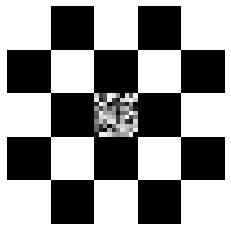

In [15]:
noise = fig.copy()
for i in range(20,30):
    for j in range(20,30):
        noise[i,j] = np.random.randint(0, 255)

plt.axis('off')
plt.imshow(noise, cmap='gray')


0.0008478803656544986 8973.08837580462
Iter: 242


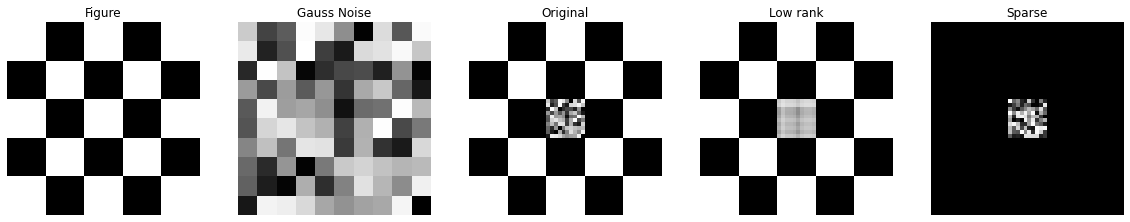

In [39]:
# RPCA
L, S = RPCAPD(noise, lamda=1.5/np.sqrt(max(img.shape)), maxIter=5000)

# Show image
plt.figure(figsize=(20, 20))
plt.subplot(1, 5, 1)
plt.axis('off')
plt.imshow(fig, cmap='gray')
plt.title('Figure')
plt.subplot(1, 5, 2)
plt.axis('off')
plt.imshow(noise[20:30,20:30], cmap='gray')
plt.title('Gauss Noise')
plt.subplot(1, 5, 3)
plt.axis('off')
plt.imshow(noise, cmap='gray')
plt.title('Original')
plt.subplot(1, 5, 4)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 5, 5)
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

Z: 0.0005004532951992564 X: 8973.08837580462
Iter: 54


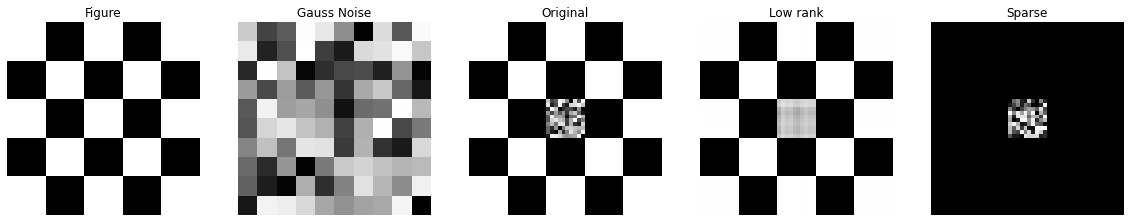

In [34]:
# RPCA
L, S = RPCA(noise, lamda=1.5/np.sqrt(max(img.shape)), mu=1e-3, maxIter=5000)

# Show image
plt.figure(figsize=(20, 20))
plt.subplot(1, 5, 1)
plt.axis('off')
plt.imshow(fig, cmap='gray')
plt.title('Figure')
plt.subplot(1, 5, 2)
plt.axis('off')
plt.imshow(noise[20:30,20:30], cmap='gray')
plt.title('Gauss Noise')
plt.subplot(1, 5, 3)
plt.axis('off')
plt.imshow(noise, cmap='gray')
plt.title('Original')
plt.subplot(1, 5, 4)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 5, 5)
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

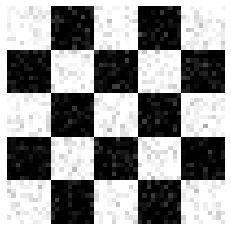

In [25]:
mean = 0
#设置高斯分布的标准差
sigma = 25
#根据均值和标准差生成符合高斯分布的噪声
gauss = np.random.normal(mean,sigma,fig.shape).astype(int)
#给图片添加高斯噪声
gauss_noisy_img = fig + gauss
#设置图片添加高斯噪声之后的像素值的范围
gauss_noisy_img = np.clip(gauss_noisy_img,a_min=0,a_max=255)

plt.axis('off')
plt.imshow(gauss_noisy_img, cmap='gray')

0.0008358591611629795 8858.924991216485
Iter: 223


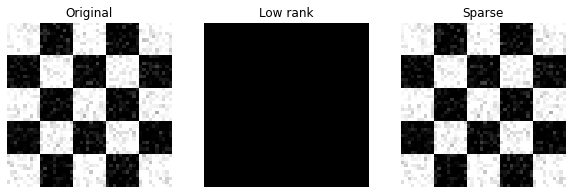

lamda =  0.1 rank =  0
0.0007995391410840428 8858.924991216485
Iter: 230


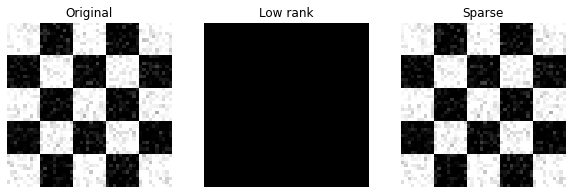

lamda =  0.2 rank =  0
0.0008742787519812665 8858.924991216485
Iter: 233


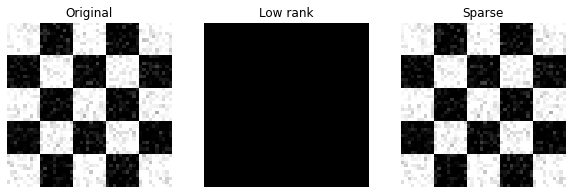

lamda =  0.3 rank =  0
0.0008497825505422914 8858.924991216485
Iter: 236


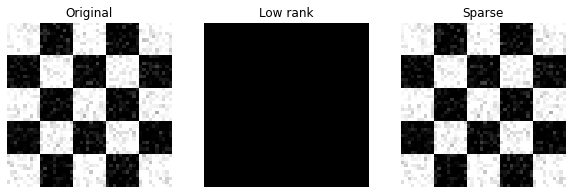

lamda =  0.4 rank =  0
0.0008532976234799783 8858.924991216485
Iter: 239


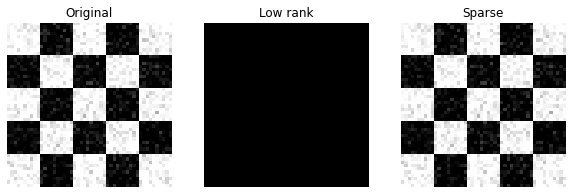

lamda =  0.5 rank =  1
0.0008484475992325512 8858.924991216485
Iter: 246


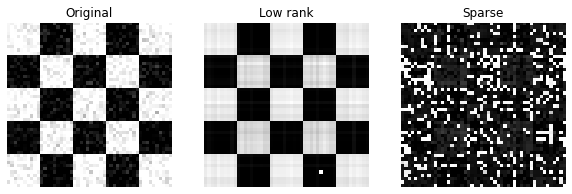

lamda =  1 rank =  2
0.0008225278192618223 8858.924991216485
Iter: 250


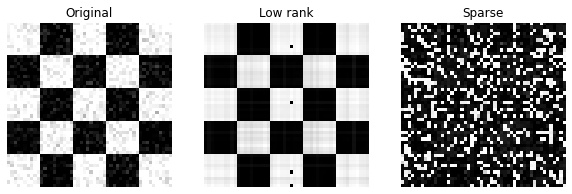

lamda =  1.5 rank =  7
0.0008087315049938886 8858.924991216485
Iter: 255


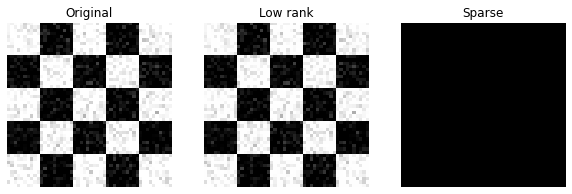

lamda =  10 rank =  50


In [56]:
for lam in [0.1,0.2,0.3,0.4, 0.5, 1, 1.5, 10]:
    # RPCA
    L, S = RPCAPD(gauss_noisy_img, lamda=lam/np.sqrt(max(img.shape)), maxIter=5000)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(gauss_noisy_img, cmap='gray')
    plt.title('Original')
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(L.astype("uint8"), cmap='gray')
    plt.title('Low rank')
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(S.astype('uint8'), cmap='gray')
    plt.title('Sparse')
    plt.show()
    print('lamda = ', lam, 'rank = ', np.linalg.matrix_rank(L))

0.0008093568229394217 8858.924991216485
Iter: 246


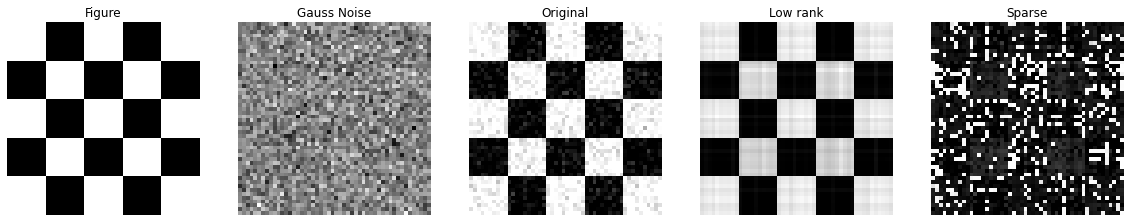

In [40]:
# RPCA
L, S = RPCAPD(gauss_noisy_img, lamda=1/np.sqrt(max(img.shape)), maxIter=5000)

# Show image
plt.figure(figsize=(20, 20))
plt.subplot(1, 5, 1)
plt.axis('off')
plt.imshow(fig, cmap='gray')
plt.title('Figure')
plt.subplot(1, 5, 2)
plt.axis('off')
plt.imshow(gauss, cmap='gray')
plt.title('Gauss Noise')
plt.subplot(1, 5, 3)
plt.axis('off')
plt.imshow(gauss_noisy_img, cmap='gray')
plt.title('Original')
plt.subplot(1, 5, 4)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 5, 5)
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

Z: 0.000803261074743986 X: 8858.924991216485
Iter: 135


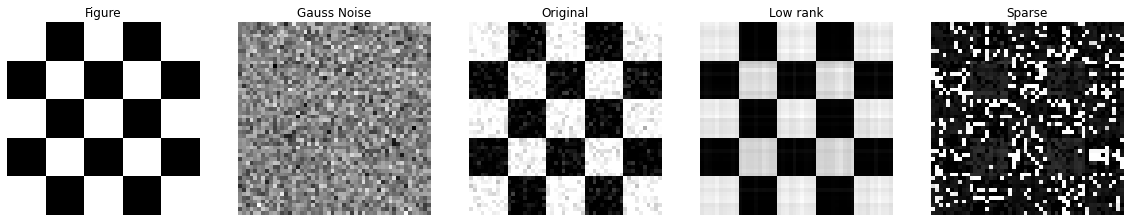

In [41]:
# RPCA
L, S = RPCA(gauss_noisy_img, lamda=1/np.sqrt(max(img.shape)), mu=1e-4, maxIter=5000)

# Show image
plt.figure(figsize=(20, 20))
plt.subplot(1, 5, 1)
plt.axis('off')
plt.imshow(fig, cmap='gray')
plt.title('Figure')
plt.subplot(1, 5, 2)
plt.axis('off')
plt.imshow(gauss, cmap='gray')
plt.title('Gauss Noise')
plt.subplot(1, 5, 3)
plt.axis('off')
plt.imshow(gauss_noisy_img, cmap='gray')
plt.title('Original')
plt.subplot(1, 5, 4)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 5, 5)
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

### 10

Z: 0.0044854863077234165 X: 45344.29984022248
Iter: 93
Z: 0.003996201175652052 X: 41728.91352527645
Iter: 92
Z: 0.0037890510945422645 X: 41098.824362747895
Iter: 95
0.004315395804648895 45344.29984022248
Iter: 266
0.004023986142499035 41728.91352527645
Iter: 265
0.003914065038728455 41098.824362747895
Iter: 265


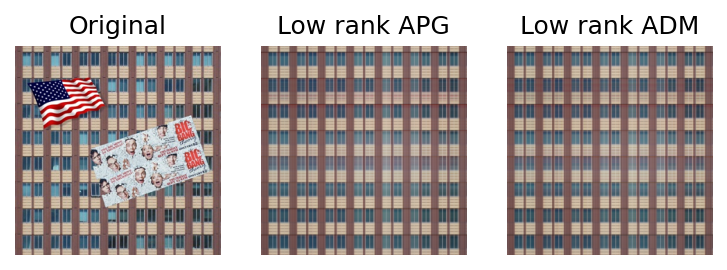

In [52]:
# Read image
img = cv2.cvtColor(cv2.imread('source/10.png'), cv2.COLOR_BGR2RGB)

L= np.zeros(img.shape)
S= np.zeros(img.shape)

for i in range(3):
    # RPCA
    L[:,:,i], S[:,:,i] = RPCA(img[:,:,i], lamda=0.2/np.sqrt(max(img.shape)) ,mu=0.0005, maxIter=5000)

# Show image
plt.figure(dpi=150)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank APG')

for i in range(3):
    # RPCA
    L[:,:,i], S[:,:,i] = RPCAPD(img[:,:,i], lamda=0.2/np.sqrt(max(img.shape)), maxIter=5000)



plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank ADM')
plt.show()

0.0036400933893003017 37119.33077252337
Iter: 273


Text(0.5, 1.0, 'Sparse')

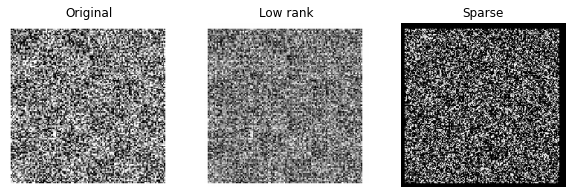

In [107]:
# Read image
img = cv2.imread('source/9.png',cv2.IMREAD_GRAYSCALE)

# RPCA
L, S = RPCAPD(img, lamda=0.8/np.sqrt(max(img.shape)), maxIter=5000)

# Show image
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')

Z: 0.0016519319698033988 X: 16682.379896165894
Iter: 71


Text(0.5, 1.0, 'Sparse')

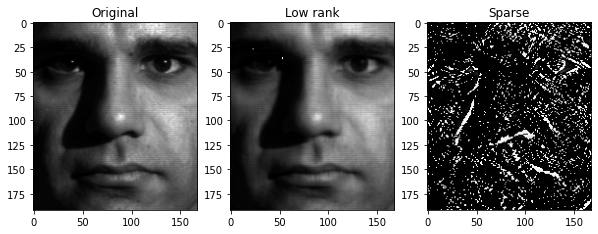

In [4]:
# Read image
img = cv2.imread('source/3.png',cv2.IMREAD_GRAYSCALE)

# RPCA
L, S = RPCA(img, lamda=1/np.sqrt(max(img.shape)), mu=1e-2, maxIter=5000)

# Show image
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 3, 3)
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')

Z: 0.004273278949636694 X: 45344.29984022248
Iter: 128
Z: 0.003922273283186707 X: 41728.91352527645
Iter: 129
Z: 0.003983930651757722 X: 41098.824362747895
Iter: 128


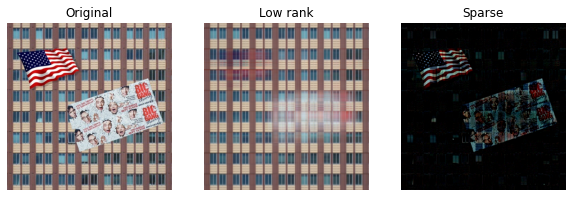

In [31]:
# Read image
img = cv2.cvtColor(cv2.imread('source/10.png'), cv2.COLOR_BGR2RGB)

L= np.zeros(img.shape)
S= np.zeros(img.shape)
for i in range(3):
    # RPCA
    L[:,:,i], S[:,:,i] = RPCA(img[:,:,i], lamda=0.4/np.sqrt(max(img.shape)), mu=0.0001, maxIter=5000)


# Show image
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

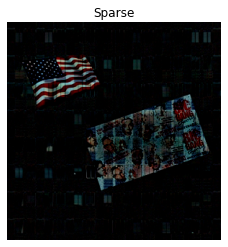

In [32]:
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


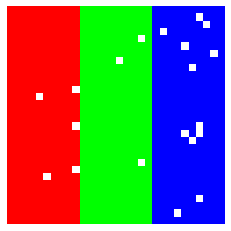

In [29]:
src1=np.zeros((30,10))+255
src2=np.zeros((30,10))+255
src3=np.zeros((30,10))+255
src = np.zeros((30,30,3))
src[:,0:10,0]=src1
src[:,10:20,1]=src2
src[:,20:30,2]=src3

r=np.random.randint(0,30,size=(20,2))

src[r[:,0],r[:,1],0]+=200
src[r[:,0],r[:,1],1]+=200
src[r[:,0],r[:,1],2]+=200

# src = src.astype(np.uint8)

plt.axis('off')
plt.imshow(src, cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Z: 0.00014732772918780277 X: 4562.619861439259
Iter: 19
Z: 0.000193863897455954 X: 4540.209246279294
Iter: 19
Z: 0.00040480526570480375 X: 4640.204736862373
Iter: 18


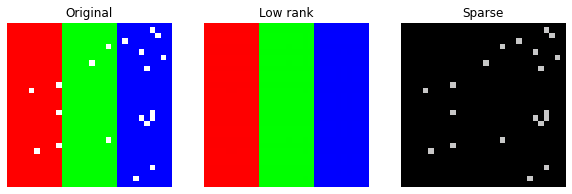

In [30]:
img=src
L= np.zeros(img.shape)
S= np.zeros(img.shape)
for i in range(3):
    # RPCA
    L[:,:,i], S[:,:,i] = RPCA(img[:,:,i], lamda=0.4/np.sqrt(max(img.shape)), mu=0.0001, maxIter=5000)


# Show image
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

0.0017333704155342202 17473.187974722874


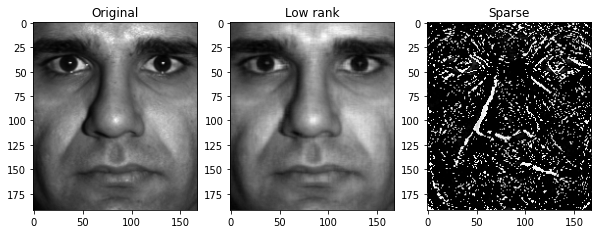

In [9]:
# Read image
img = cv2.imread('source/2.png',cv2.IMREAD_GRAYSCALE)

# RPCA
L, S = RPCAPD(img, lamda=1/np.sqrt(max(img.shape)), maxIter=5000)

# Show image
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 3, 3)
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

0.0009322640289766491 9860.07966499257


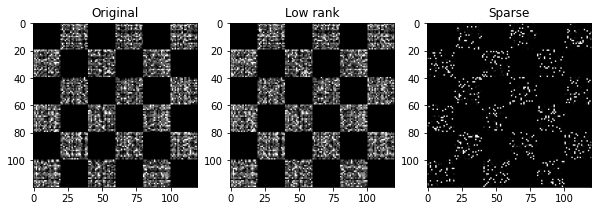

In [10]:
# Read image
img = cv2.imread('source/6.png',cv2.IMREAD_GRAYSCALE)

# RPCA
L, S = RPCAPD(img, lamda=1.8/np.sqrt(max(img.shape)), mu=1000000000, maxIter=5000)

# Show image
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 3, 3)
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

Z: 0.00045223832021241235 X: 48267.80215630291
Iter: 12
Z: 0.0009749459333649377 X: 48270.49642379908
Iter: 12
Z: 0.0020726356413858743 X: 48252.30719872367
Iter: 11


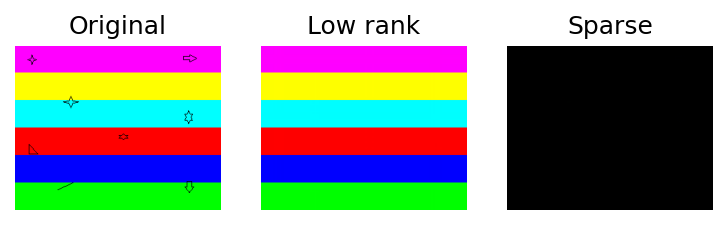

In [127]:
# Read image
img = cv2.cvtColor(cv2.imread('source/colorbox11.bmp'), cv2.COLOR_BGR2RGB)

L= np.zeros(img.shape)
S= np.zeros(img.shape)
for i in range(3):
    # RPCA
    L[:,:,i], S[:,:,i] = RPCA(img[:,:,i], lamda=0.7/np.sqrt(max(img.shape)), mu=0.0005,maxIter=5000)


# Show image
plt.figure(dpi=150)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(S.astype('uint8'), cmap='gray')
plt.title('Sparse')
plt.show()

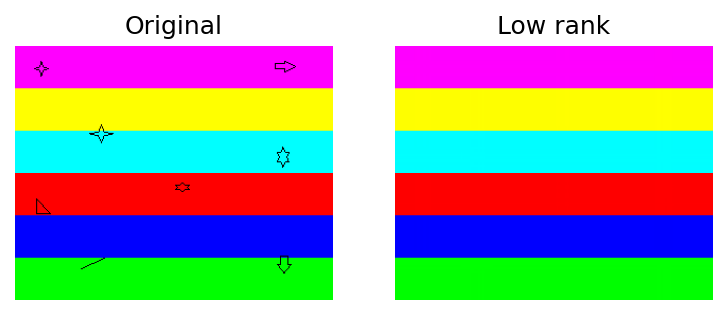

In [128]:
plt.figure(dpi=150)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(L.astype("uint8"), cmap='gray')
plt.title('Low rank')
plt.show()